<a href="https://colab.research.google.com/github/Jay-hv7/DL-Practice/blob/main/computer_vision_revisit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps
- Get the data ready (turn into tensors)
- Build or pick a pretrained model (optimize)
- Fit the model to the data and make a prediction
- Evaluate the model
- Improve through experimentation
- Save and reload the trained model

# Library
### Data:
``` bash
- torchvision.transforms
- torch.utils.data.Dataset
- torch.utils.data.DataLoader
```
### Build model
``` bash
- torch.nn
- torch.nn.Module
- torchvision.models
- torch.optim
```
### Evaluate model
``` bash
- torchmetrics
```
### Experimentation
``` bash
- torch.utils.tensorboard
```
### save and reload
``` bash
- torch.save
- torch.load
```

### Convolutional Neural Network
- ChatGPT said:

A Convolutional Neural Network (CNN) is a specialized type of deep neural network designed to automatically learn patterns from image data (and sometimes audio or other grid-like data).

It is especially good at detecting spatial patterns like edges, shapes, textures, and objects.

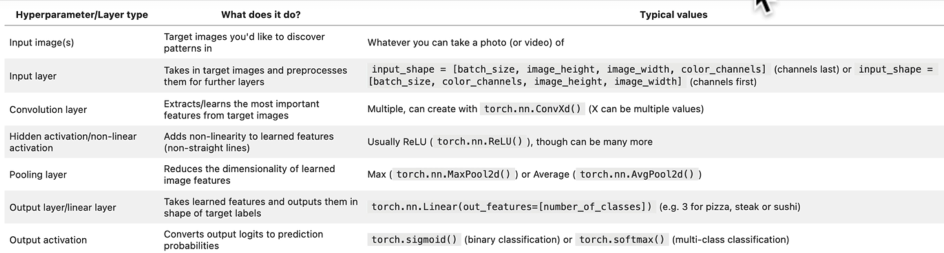

### Example : reference https://medium.com/@draj0718/convolutional-neural-networks-cnn-architectures-explained-716fb197b243
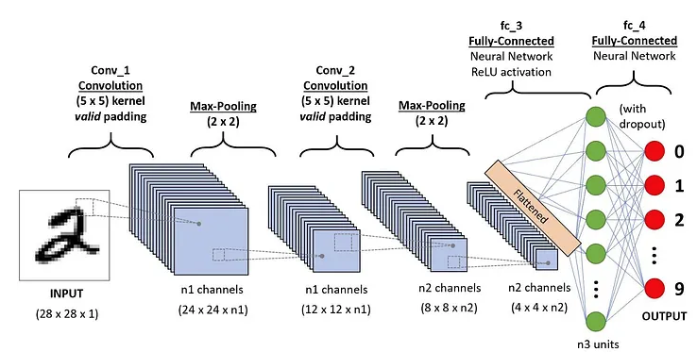

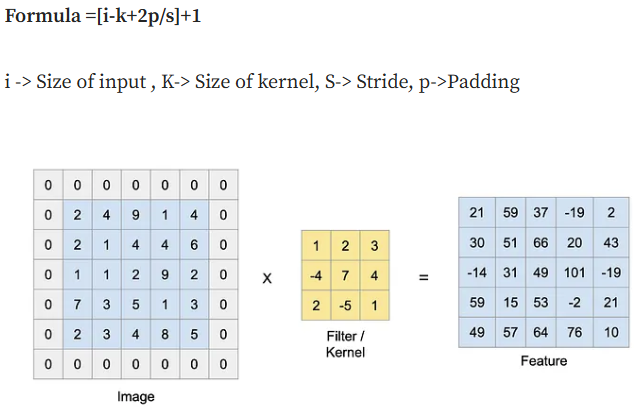

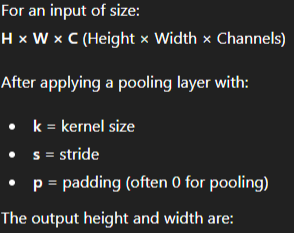


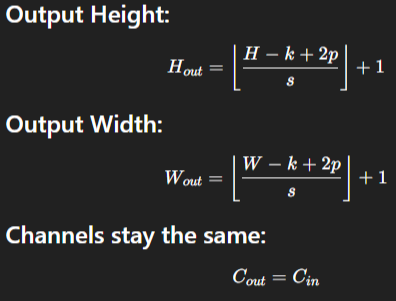

In [1]:
# Import libraries
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor  # converts PIL Image or ndarray to tensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

#check versions
print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


# 1. Getting Dataset (FashionMNIST - handwritten digits  image dataset) from torchvision.datasets https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html


In [2]:
# setup data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    target_transform=None,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_data =  datasets.FashionMNIST(
    root="data",
    train=False,
    target_transform=None,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.76MB/s]


In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image,label=train_data[0]
image.shape

torch.Size([1, 28, 28])

In [5]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
print("label ",label)

label  9


### Visualizing Data

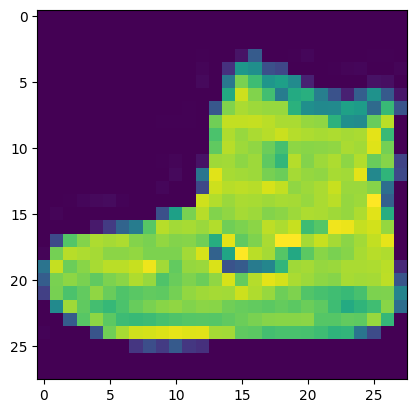

In [7]:
plt.imshow(image.squeeze())  # to remove 1 from shape

In [8]:
class_names = train_data.classes
print("Class names",class_names)

Class names ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

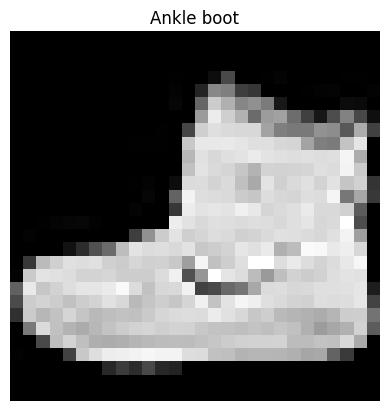

In [9]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

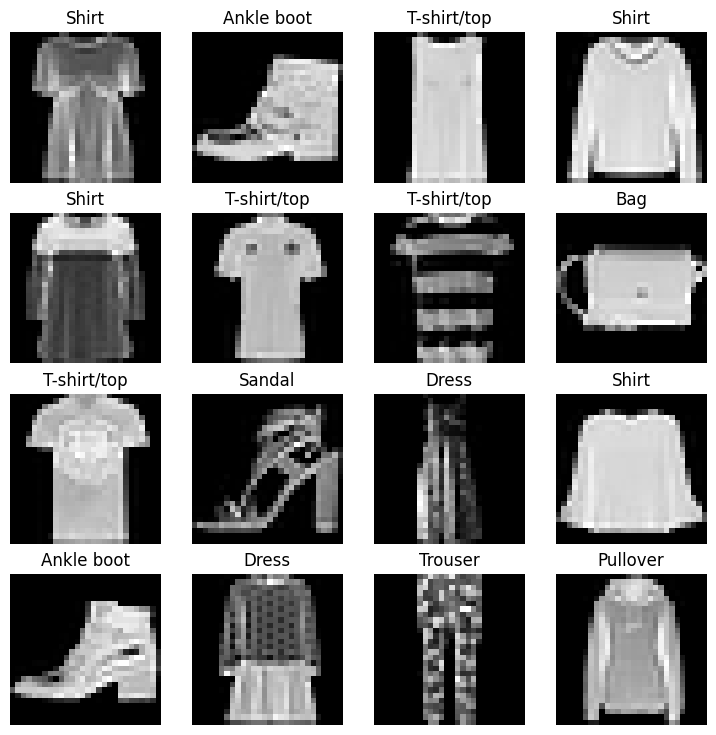

In [10]:
# plot more images
torch.manual_seed(0)
fig = plt.figure(figsize=(9,9))
rows,cols = 4, 4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0, len(train_data),size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)

In [11]:
# Prepare Data Loader
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

##### Prepared dataset with DataLoader
- group the data to batches (ex; batch size=32
- gradients are updated in each epoch
- DataLoader turns data into batches from pytorch dataset to python iterable

In [12]:
BATCH_SIZE=32
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # mix samples with different labels
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

In [13]:
print(f"length of train_dataloader {len(train_dataloader)}")

length of train_dataloader 1875


In [14]:
print(f"length of train_dataloader {len(train_dataloader)}")
print(f"length of train dataset {len(train_data)}, batch size = {BATCH_SIZE}, len(train_dataloader = len(train_data)/BATCH_SIZE) = {len(train_data)/BATCH_SIZE}")

length of train_dataloader 1875
length of train dataset 60000, batch size = 32, len(train_dataloader = len(train_data)/BATCH_SIZE) = 1875.0


In [15]:
print(f"length of test dataset {len(test_data)}, batch size = {BATCH_SIZE}, len(test_dataloader = len(test_data)/BATCH_SIZE) = {round(len(test_data)/BATCH_SIZE)}")

length of test dataset 10000, batch size = 32, len(test_dataloader = len(test_data)/BATCH_SIZE) = 312


In [16]:
train_data_batch, train_labels_batch = next(iter(train_dataloader))
train_data_batch.shape, train_labels_batch.shape # 32 samples (batch size) in one batch NCHW format


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

img shape torch.Size([1, 28, 28])
Label 5, label shape = torch.Size([])


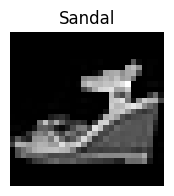

In [17]:
random_sample_id = torch.randint(0, len(train_data_batch), size=[1]).item()
img, label = train_data_batch[random_sample_id], train_labels_batch[random_sample_id]
plt.figure(figsize=(2,2))
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"img shape {img.shape}")
print(f"Label {label}, label shape = {label.shape}")

In [18]:
## Build a baseline model
flatten_model = nn.Flatten()

# Get a single sample
x = train_data_batch[0]

# Flattent the sample
output = flatten_model(x)

print(f"sample before flatten = {x.shape}, sample after = {output.shape}")

sample before flatten = torch.Size([1, 28, 28]), sample after = torch.Size([1, 784])


# CNN Convolutional Neural Network


In [101]:
from torch.nn.modules.pooling import MaxPool2d
# Crete convolutional neural network (conv + ReLU + Pooling)
class FashionMNISTModel(nn.Module):
  """
  Model architecture that replicates TinyVGG
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )
  def forward(self,x):
    x = self.conv_block_1(x)
    # print("after conv1",x.shape)
    x = self.conv_block_2(x)
    # print("after conv2",x.shape)
    x= self.classifier(x)
    # print("after classifier",x.shape)

    return x


In [102]:
len(class_names)

10

In [103]:
device='cpu'

In [104]:
torch.manual_seed(42)
model_cnn = FashionMNISTModel(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [105]:
images = torch.randn(size=(32,3,64,64))
test_image = images[0]
print(f"Image batch shape {images.shape}, single image shape = {test_image.shape}")

Image batch shape torch.Size([32, 3, 64, 64]), single image shape = torch.Size([3, 64, 64])


In [106]:
model_cnn.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [107]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

In [108]:
test_image.shape

torch.Size([3, 64, 64])

In [109]:
test_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [110]:
conv_output = conv_layer(test_image.unsqueeze(0))

In [111]:
print(conv_output.shape)

torch.Size([1, 10, 64, 64])


In [112]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,  # 10 hidden layer
                       kernel_size=3,
                       stride=1,
                       padding=1)

In [113]:
conv_output = conv_layer(test_image.unsqueeze(0))
print(conv_output.shape)

torch.Size([1, 10, 64, 64])


In [114]:
# original image shape
print(test_image.shape)

torch.Size([3, 64, 64])


In [115]:
print(test_image.unsqueeze(0).shape)

torch.Size([1, 3, 64, 64])


In [116]:
max_pool_layer = nn.MaxPool2d(kernel_size=2) # divides input image by kernel size
test_image_thr_conv = conv_layer(test_image.unsqueeze(dim=0))
print(test_image_thr_conv.shape)
test_image_thr_max_pool = max_pool_layer(test_image_thr_conv)
print(test_image_thr_max_pool.shape)

torch.Size([1, 10, 64, 64])
torch.Size([1, 10, 32, 32])


In [117]:
rand_tensor = torch.randn(size=(1,28,28))
model_cnn(rand_tensor.unsqueeze(dim=0)).to(device)

tensor([[ 0.0448, -0.0983,  0.0744, -0.0535,  0.0090,  0.0291,  0.0190,  0.0015,
         -0.0109, -0.0175]], grad_fn=<AddmmBackward0>)

### Setup a loss function and optimizer

In [118]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [119]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn.parameters(), lr=0.1)

In [120]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()  # set model to training mode

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 4. Accuracy
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += accuracy_fn(y, y_pred_class)

    # return average metrics for the epoch
    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)

    return train_loss, train_acc


In [121]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    model.eval()                 # set model to evaluation mode

    test_loss, test_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (no backward pass)
        y_pred = model(X)

        # 2. Loss
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()

        # 3. Accuracy
        y_pred_class = torch.argmax(y_pred, dim=1)
        test_acc += accuracy_fn(y, y_pred_class)

    # return average metrics
    test_loss = test_loss / len(data_loader)
    test_acc = test_acc / len(data_loader)

    return test_loss, test_acc

In [122]:
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


### Training and Testing

In [124]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model2 = timer()
from tqdm import tqdm


# Train test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"epoch = {epoch} \n")
  train_loss, train_acc = train_step(
        model=model_cnn,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
  test_loss, test_acc = test_step(
      model=model_cnn,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
  )

  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}\n")
  print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\n")
train_time_end_model_cnn = timer()
total_train_time_model_cnn = print_train_time(start=train_time_start_model2,
                                              end=train_time_end_model_cnn,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch = 0 



 33%|███▎      | 1/3 [01:28<02:56, 88.42s/it]

Train Loss: 0.4003, Train Acc: 85.6633

Test Loss: 0.3367, Test Acc: 87.6617

epoch = 1 



 67%|██████▋   | 2/3 [02:57<01:28, 88.60s/it]

Train Loss: 0.3430, Train Acc: 87.5183

Test Loss: 0.3409, Test Acc: 88.0283

epoch = 2 



100%|██████████| 3/3 [04:24<00:00, 88.25s/it]

Train Loss: 0.3153, Train Acc: 88.5750

Test Loss: 0.3113, Test Acc: 88.6467


Train time on cpu: 264.769 seconds


### Confusion matrix

In [125]:
import mlxtend

In [126]:
mlxtend.__version__

'0.23.4'

In [132]:
from tqdm.auto import tqdm
y_preds=[]
model_cnn.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc="making predictions .."):
    X, y = X.to(device), y.to(device)
    y_logits = model_cnn(X)

    # logits to prediction probabilities to labels
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    # predictions
    y_preds.append(y_pred.cpu())
print(len(y_preds))  # has for each batch one prediction, 10000 (Test data)/batch size(32)= 312.5 predictions 313 . 1 tensor per batch
y_pred_tensor = torch.cat(y_preds) # merges all tensors
print(len(y_pred_tensor))
y_pred_tensor[:10]

making predictions ..:   0%|          | 0/313 [00:00<?, ?it/s]

313
10000


tensor([6, 8, 8, 5, 0, 6, 3, 0, 9, 7])

In [134]:
try:
  import torchmetrics
  print(f"versions {torchmetrics.__version}")
  assert int(mlxtend.__version__.split(".")[1]>=19, "it is higher")
except:
  ! pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.6 MB/s eta 0:00:00


In [135]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [138]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names),task="multiclass")
confmat_tensor = confmat(preds =y_pred_tensor,
                         target = test_data.targets)


In [139]:
print(confmat_tensor)

tensor([[ 64,  79, 119, 102, 121,  78, 104, 133, 108,  92],
        [ 69,  95, 119, 101, 120,  88, 116, 116,  93,  83],
        [ 52,  86, 123, 121, 121,  90,  89, 117, 107,  94],
        [ 63,  90, 109, 120, 123,  90,  98, 112, 104,  91],
        [ 57,  98, 132, 116, 114,  71, 109,  87, 108, 108],
        [ 73, 110, 113, 106, 132,  74,  95, 104, 104,  89],
        [ 44, 113, 118,  93, 109,  96, 112, 115, 107,  93],
        [ 64,  83, 115, 114, 129,  82,  83, 115, 120,  95],
        [ 63,  87, 113, 114, 120,  80, 109, 121,  86, 107],
        [ 72, 104, 113, 119, 124,  93,  84, 103,  98,  90]])


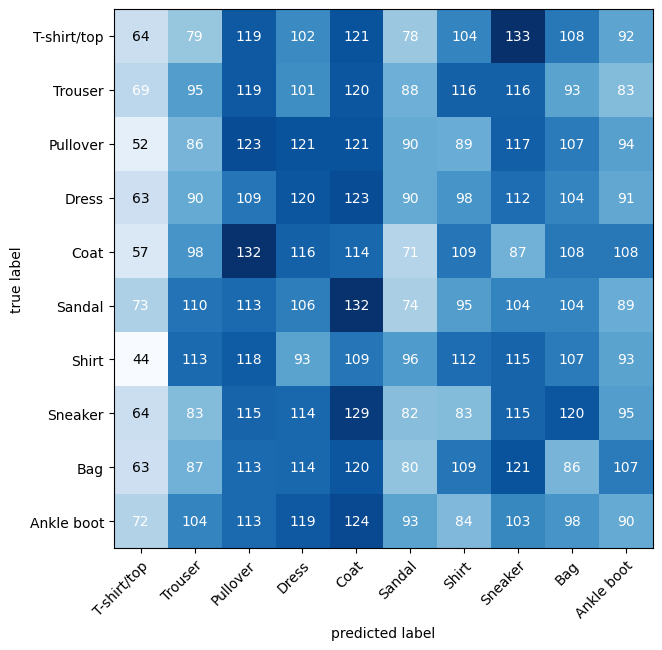

In [140]:
# plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

# Saving and Loading the model

In [142]:
from pathlib import Path
# create model directory path
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# model save
MODEL_NAME="CNN_model_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#save the model state dict
torch.save(obj=model_cnn.state_dict(),f=MODEL_SAVE_PATH)

In [144]:
#LOad the model
FashionMNISTModel_loaded = FashionMNISTModel(input_shape=1,
                                             hidden_units=10,
                                             output_shape=len(class_names))

# Load in the save state_dict
FashionMNISTModel_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
# send the model to target device
FashionMNISTModel_loaded.to(device)

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [146]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [147]:
# Evaluate loaded model
torch.manual_seed(42)
FashionMNISTModel_loaded_results = eval_model(
    model=FashionMNISTModel_loaded,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn

)
print(FashionMNISTModel_loaded_results)

{'model_name': 'FashionMNISTModel', 'model_loss': 0.34109702706336975, 'model_acc': 87.75958466453675}
